In [ ]:
#Fill missing latitude/longitude with country averages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

df = pd.read_csv("EuCitiesTemperatures.csv")

#fill missing lat/lon values with average for that country
df['latitude'] = df.groupby('country')['latitude'].transform(lambda x: x.fillna(round(x.mean(), 2)))
df['longitude'] = df.groupby('country')['longitude'].transform(lambda x: x.fillna(round(x.mean(), 2)))

#verify filled values
print("After filling missing values:")
print(df[['city', 'country', 'latitude', 'longitude']].head(10))

After filling missing values:
        city  country  latitude  longitude
0    Elbasan  Albania     41.12      20.08
1    Andorra  Andorra     42.50       1.52
2  Innsbruck  Austria     47.85      11.41
3       Graz  Austria     47.08      14.02
4       Linz  Austria     48.32      14.29
5   Salzburg  Austria     47.81      14.02
6     Vienna  Austria     48.20      16.37
7      Minsk  Belarus     52.61      27.57
8      Orsha  Belarus     52.61      25.64
9      Pinsk  Belarus     52.61      25.64


In [3]:
#find subset of cities between lat 40-60 and lon 15-30
filtered_cities = df[(df['latitude'] >= 40) & (df['longitude'] <= 60) &
                    (df['longitude'] >= 15) & (df['longitude'] <= 30)]

#Count cities per country in this region 
country_counts = filtered_cities['country'].value_counts()
max_count = country_counts.max()
countries_with_max = country_counts[country_counts == max_count].index.tolist()

print("\nCountries with maximum cities in the specified region (lat 40-60, lon 15-30):")
print(f"Countries: {countries_with_max} with {max_count} cities each")
print("\nAll countries and their city counts in this region:")
print(country_counts)


Countries with maximum cities in the specified region (lat 40-60, lon 15-30):
Countries: ['Romania', 'Poland'] with 9 cities each

All countries and their city counts in this region:
country
Romania           9
Poland            9
Belarus           6
Bulgaria          5
Sweden            5
Finland           4
Hungary           4
Lithuania         3
Turkey            3
Serbia            3
Moldova           2
Slovakia          2
Ukraine           2
Latvia            2
Italy             2
Estonia           2
Czech Republic    2
Macedonia         1
Montenegro        1
Austria           1
Croatia           1
Albania           1
Name: count, dtype: int64


In [4]:
#fill missing temperature values by region type average 
#create region type (combination of EU and coastline)
df['region_type'] = df['EU'].astype(str) + '_' + df['coastline'].astype(str)

#calculate average temperature by region type 
region_avg_temp = df.groupby('region_type')['temperature'].mean()

#fill missing temperature values 
for region in df['region_type'].unique():
    mask = (df['region_type'] == region) & (df['temperature'].isna())
    df.loc[mask, 'temperature'] = region_avg_temp[region]
    
#verify temperature filling 
print("\nAfter filling missing temperature values by region type:")
print(df[['city', 'country', 'region_type', 'temperature']].head(10))

region_count = df['region_type'].value_counts()
print("\nNumber of cities in each region type:")
print(region_count)


After filling missing temperature values by region type:
        city  country region_type  temperature
0    Elbasan  Albania      no_yes    15.180000
1    Andorra  Andorra       no_no     7.481538
2  Innsbruck  Austria      yes_no     4.540000
3       Graz  Austria      yes_no     6.910000
4       Linz  Austria      yes_no     6.790000
5   Salzburg  Austria      yes_no     4.620000
6     Vienna  Austria      yes_no     7.860000
7      Minsk  Belarus       no_no     5.280000
8      Orsha  Belarus       no_no     4.930000
9      Pinsk  Belarus       no_no     6.420000

Number of cities in each region type:
region_type
yes_yes    136
no_yes      47
no_no       16
yes_no      14
Name: count, dtype: int64


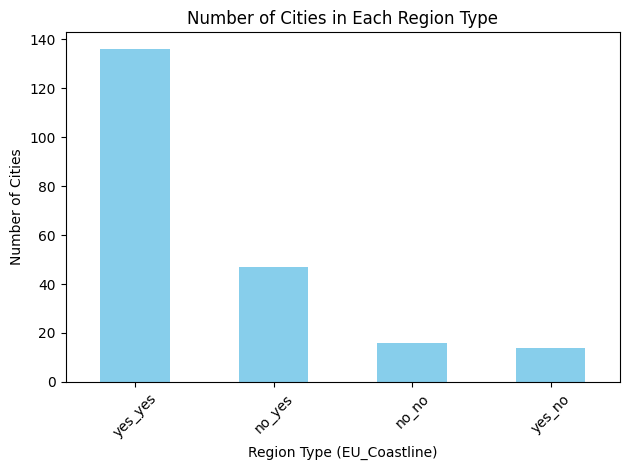

In [6]:
#visualization
#bar chart for number of cities in each region type
plt.Figure(figsize=(10, 6))
region_count.plot(kind='bar', color='skyblue')
plt.title('Number of Cities in Each Region Type')
plt.xlabel('Region Type (EU_Coastline)')
plt.ylabel('Number of Cities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

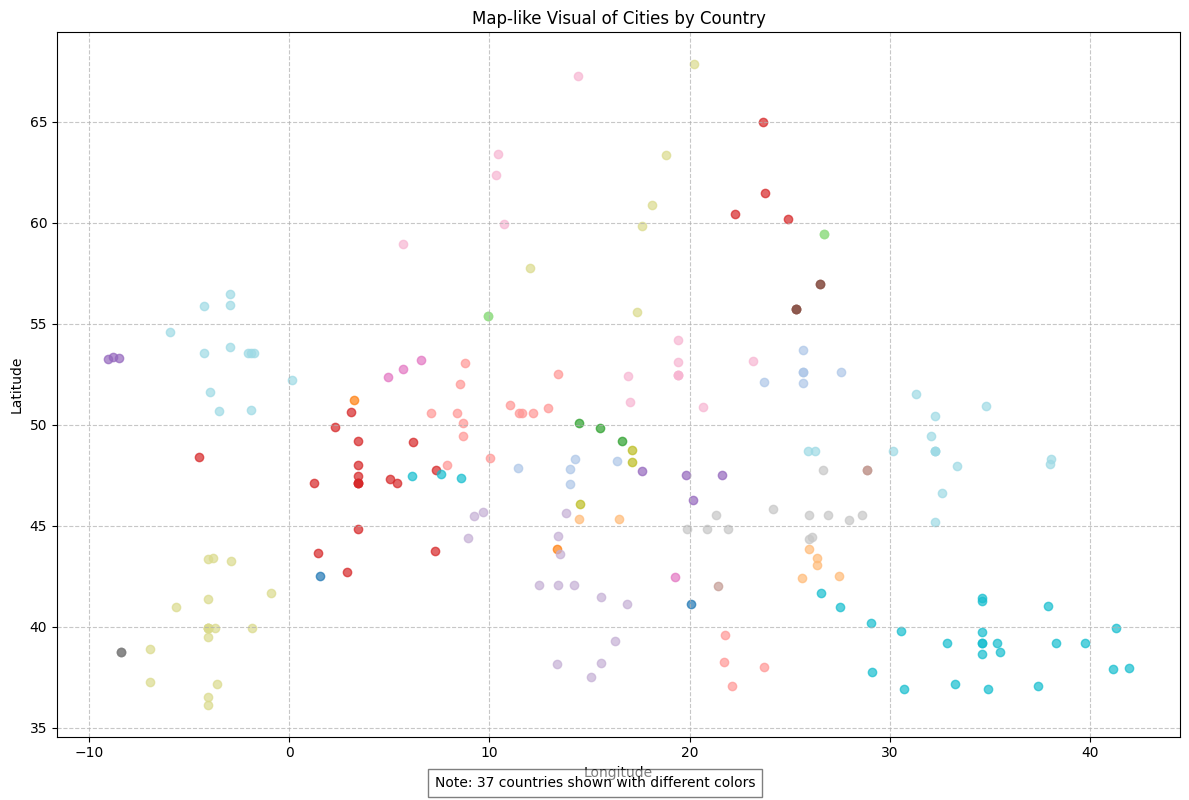

In [7]:
#scatter plot of latitude vs longitude with countries in different colors
plt.figure(figsize=(12, 8))

#get unique countries for colors 
countries = df['country'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    country_data = df[df['country'] == country]
    plt.scatter(country_data['longitude'], country_data['latitude'],
                label=country, color=colors[i], alpha=0.7)

plt.title('Map-like Visual of Cities by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)

#handle legend, for many countries
if len(countries) <= 20: #Only show legend if there are not too many countries
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    #alternative is to show a few major countries or add a text note
    plt.figtext(0.5, 0.01, f"Note: {len(countries)} countries shown with different colors", 
                ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
plt.tight_layout()
plt.show()

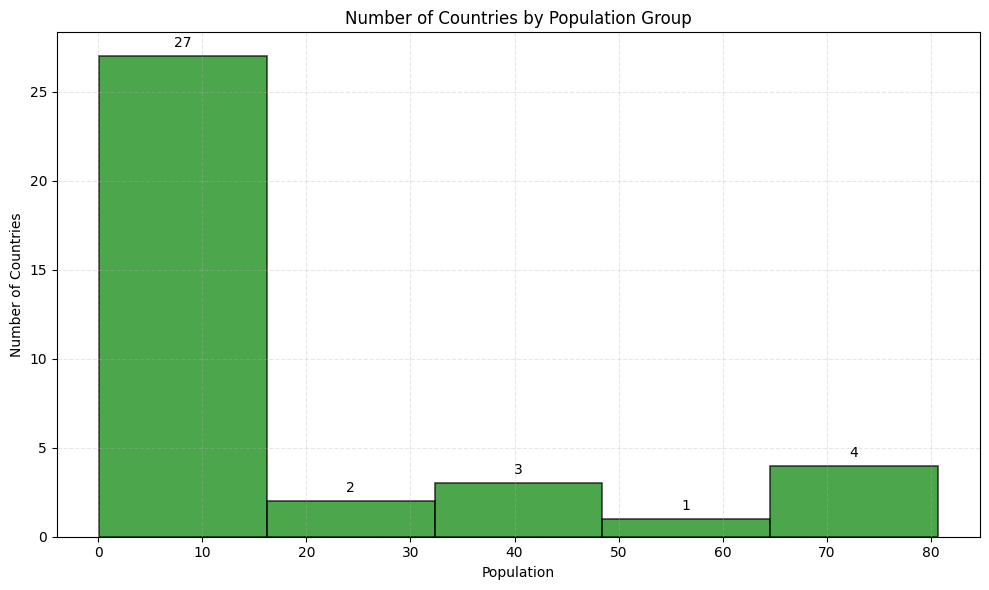

In [8]:
#histogram of countries by population group 
#since population is same for all cities in a country, get unique country-population pairs
country_pop = df[['country', 'population']].drop_duplicates()

plt.figure(figsize=(10, 6))
hist = plt.hist(country_pop['population'], bins=5, color='green', alpha=0.7,
                edgecolor='black', linewidth=1.2)

#add labels to show the count in each bin 
for i in range(len(hist[0])):
    plt.text(hist[1][i] + (hist[1][i+1] - hist[1][i])/2, hist[0][i] + 0.5, 
            int(hist[0][i]), ha='center')
    
plt.title('Number of Countries by Population Group')
plt.xlabel('Population')
plt.ylabel('Number of Countries')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

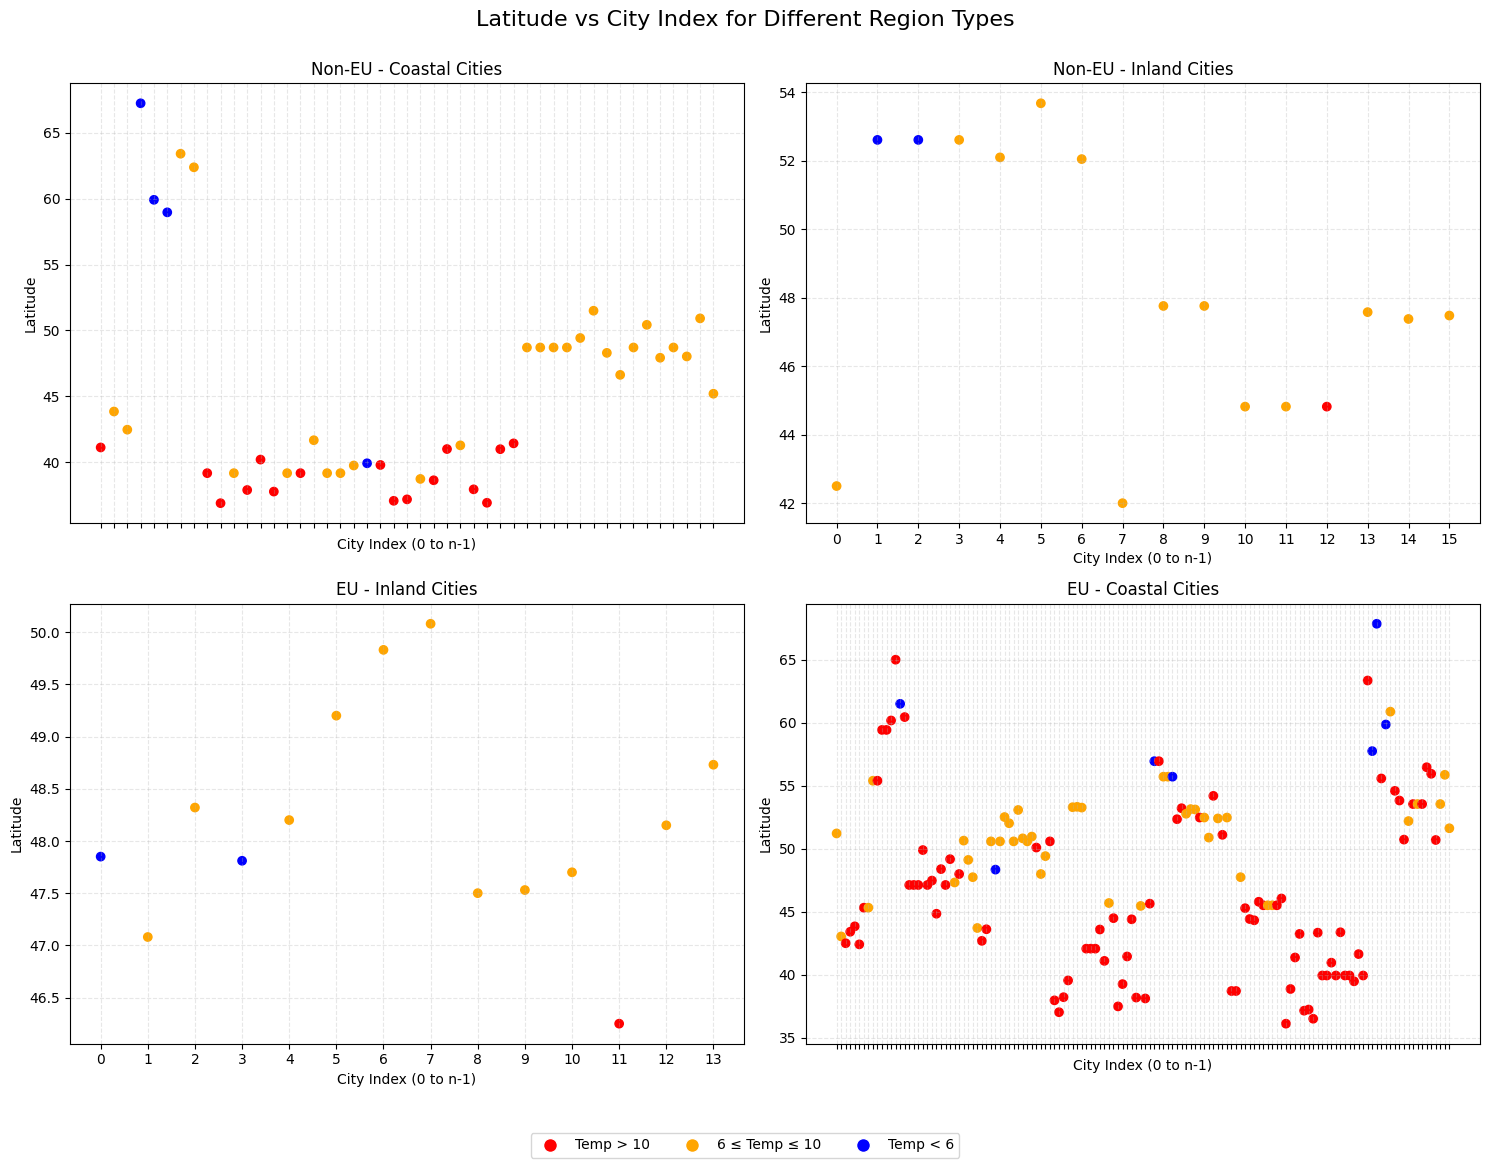

In [9]:
#subplots for each region type
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

#get unique region types
region_types = df['region_type'].unique()

for i, region in enumerate(region_types):
    if i >= 4: #more than 4 region types
        break
    
    region_data = df[df['region_type'] == region].copy()
    region_data = region_data.reset_index(drop=True)
    
    #Define colors based on temperature 
    colors = []
    for temp in region_data['temperature']:
        if temp < 6:
            colors.append('blue')
        elif 6 <= temp <= 10:
            colors.append('orange')
        else: 
            colors.append('red')
            
    axes[i].scatter(range(len(region_data)), region_data['latitude'], c=colors)
    
    #set x=tricks from 0 to n-1
    axes[i].set_xticks(range(len(region_data)))
    #remove tick labels for readability if too many points 
    if len(region_data) > 20:
        axes[i].set_xticklabels([])
        
    #represent EU and coastline values in a readable way for the title 
    eu_status = "EU" if region.split('_')[0] == 'yes' else "Non-EU"
    coast_status = "Coastal" if region.split('_')[1] == 'yes' else "Inland"
    
    axes[i].set_title(f'{eu_status} - {coast_status} Cities')
    axes[i].set_xlabel('City Index (0 to n-1)')
    axes[i].set_ylabel('Latitude')
    axes[i].grid(True, linestyle='--', alpha=0.3)
    
#add legend 
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Temp > 10'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='6 ≤ Temp ≤ 10'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Temp < 6')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)

#if we have fewer than 4 region types, hide the unused subplots
for j in range(i+1, 4):
    axes[j].set_visible(False)
    
plt.tight_layout(rect=[0, 0.07, 1, 0.95])  
plt.suptitle('Latitude vs City Index for Different Region Types', fontsize=16)
plt.show()